In [1]:
# Part 0: Setup
# Run this first cell
!pip install --quiet chart_studio
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Display matplotlib plots inline
%matplotlib inline

# Path to dataset (change if needed)
csv_path = "/content/Netflix Dataset.csv"

# quick check
print("File exists:", os.path.exists(csv_path))
print("Using path:", csv_path)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 3.0 MB/s eta 0:00:00
File exists: True
Using path: /content/Netflix Dataset.csv


In [3]:
# Part 0: Setup
# Run this first cell
!pip install --quiet chart_studio
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Display matplotlib plots inline
%matplotlib inline

# Path to dataset (change if needed)
csv_path = "/content/Netflix Dataset.csv"

# quick check
print("File exists:", os.path.exists(csv_path))
print("Using path:", csv_path)


File exists: True
Using path: /content/Netflix Dataset.csv


In [4]:
# Part 1: Load data
df = pd.read_csv(csv_path)
print("Rows,Cols:", df.shape)
display(df.head())
display(df.info())
display(df.describe(include='all').T)


Rows,Cols: (7789, 11)


,Show_Id,Category,Title,Director,Cast,Country,Release_Date,Rating,Duration,Type,Description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",PG-13,123 min,Dramas,A brilliant group of students become card-coun...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7789 entries, 0 to 7788
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Show_Id       7789 non-null   object
 1   Category      7789 non-null   object
 2   Title         7789 non-null   object
 3   Director      5401 non-null   object
 4   Cast          7071 non-null   object
 5   Country       7282 non-null   object
 6   Release_Date  7779 non-null   object
 7   Rating        7782 non-null   object
 8   Duration      7789 non-null   object
 9   Type          7789 non-null   object
 10  Description   7789 non-null   object
dtypes: object(11)
memory usage: 669.5+ KB


None

,count,unique,top,freq
Show_Id,7789,7787,s6621,2
Category,7789,2,Movie,5379
Title,7789,7787,The Lost Okoroshi,2
Director,5401,4050,"Raúl Campos, Jan Suter",18
Cast,7071,6831,David Attenborough,18
Country,7282,681,United States,2556
Release_Date,7779,1512,"January 1, 2020",119
Rating,7782,14,TV-MA,2865
Duration,7789,216,1 Season,1608
Type,7789,492,Documentaries,334


In [5]:
# Part 2: Columns and cleanup column names
print("Columns:", df.columns.tolist())

# common cleanups (optional) - make column names lowercase & strip
df.columns = [c.strip().replace(' ', '_').lower() for c in df.columns]
print("New columns:", df.columns.tolist())


Columns: ['Show_Id', 'Category', 'Title', 'Director', 'Cast', 'Country', 'Release_Date', 'Rating', 'Duration', 'Type', 'Description']
New columns: ['show_id', 'category', 'title', 'director', 'cast', 'country', 'release_date', 'rating', 'duration', 'type', 'description']


In [6]:
# Part 3: Missing values
missing = df.isnull().sum().sort_values(ascending=False)
display(missing[missing>0])

# Example cleaning steps (adjust based on columns present)
# If 'date_added' column exists, parse dates
if 'date_added' in df.columns:
    df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

# Strip strings in text columns
text_cols = df.select_dtypes(include='object').columns
for c in text_cols:
    df[c] = df[c].astype(str).str.strip().replace('nan','', regex=False)

# Drop exact duplicate rows
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"Dropped duplicates: {before-after}")


,0
director,2388
cast,718
country,507
release_date,10
rating,7


Dropped duplicates: 2


In [9]:
# Part 4: Feature engineering
# 1) release_year (if present)
if 'release_date' in df.columns:
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
    df['release_year'] = df['release_date'].dt.year

# 2) if duration like "90 min" or "2 Seasons" -> extract numeric and unit
if 'duration' in df.columns:
    # create duration_num and duration_unit
    import re
    def parse_duration(x):
        x = str(x)
        m = re.search(r'(\d+)', x)
        unit = 'other'
        if 'season' in x.lower():
            unit = 'seasons'
        elif 'min' in x.lower():
            unit = 'minutes'
        elif 'episode' in x.lower():
            unit = 'episodes'
        return pd.Series([pd.to_numeric(m.group(1)) if m else np.nan, unit])
    df[['duration_num','duration_unit']] = df['duration'].apply(parse_duration)

# 3) Convert 'listed_in' or 'type' to genres list (column name may vary)
genre_col = None
for candidate in ['listed_in','genres','type','category']:
    if candidate in df.columns:
        genre_col = candidate
        break

if genre_col:
    # split by comma and strip
    df['genres_list'] = df[genre_col].apply(lambda x: [g.strip() for g in str(x).split(',')] if x else [])
else:
    df['genres_list'] = [[]]

# show small sample
display(df[['title','type','release_year','duration','duration_num','duration_unit','genres_list']].head())

,title,type,release_year,duration,duration_num,duration_unit,genres_list
0,3%,"International TV Shows, TV Dramas, TV Sci-Fi &...",2020.0,4 Seasons,4,seasons,"[International TV Shows, TV Dramas, TV Sci-Fi ..."
1,7:19,"Dramas, International Movies",2016.0,93 min,93,minutes,"[Dramas, International Movies]"
2,23:59,"Horror Movies, International Movies",2018.0,78 min,78,minutes,"[Horror Movies, International Movies]"
3,9,"Action & Adventure, Independent Movies, Sci-Fi...",2017.0,80 min,80,minutes,"[Action & Adventure, Independent Movies, Sci-F..."
4,21,Dramas,2020.0,123 min,123,minutes,[Dramas]


In [11]:
# Part 5: Movies vs TV Shows distribution over years
# Part 5A
# Ensure imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")

# Detect/normalize type column and year column
print("Columns:", df.columns.tolist())

# Normalize type column name variants
type_candidates = [c for c in df.columns if c.lower() == 'type' or 'type' in c.lower()]
type_col = type_candidates[0] if type_candidates else None

if not type_col:
    raise ValueError("No 'type' column found in dataset. Check column names.")

# Show distinct values in type column (so we can map to 'Movie'/'TV Show' if needed)
print("Unique values in type column:", df[type_col].unique()[:50])

# Normalize values to consistent categories
df[type_col] = df[type_col].str.strip().str.title()  # "Movie" / "Tv Show" typical
# Map common variations if any
mapping = {
    'Tv Show': 'TV Show',
    'Tv-Show': 'TV Show',
    'Tv Show ': 'TV Show',
    'Movie ': 'Movie',
    'Film': 'Movie'
}
df[type_col] = df[type_col].replace(mapping)

# Determine year column: prefer 'release_year', else 'date_added' year
if 'release_year' in df.columns:
    year_col = 'release_year'
    df[year_col] = pd.to_numeric(df[year_col], errors='coerce').astype('Int64')
elif 'date_added' in df.columns:
    df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
    df['added_year'] = df['date_added'].dt.year
    year_col = 'added_year'
else:
    # try find any column with 'year' in name
    cand = [c for c in df.columns if 'year' in c.lower()]
    if cand:
        year_col = cand[0]
        df[year_col] = pd.to_numeric(df[year_col], errors='coerce').astype('Int64')
    else:
        raise ValueError("No suitable year column found (release_year or date_added).")

print("Using type column:", type_col, "and year column:", year_col)
print("Year column sample values:", df[year_col].dropna().unique()[:10])


Columns: ['show_id', 'category', 'title', 'director', 'cast', 'country', 'release_date', 'rating', 'duration', 'type', 'description', 'duration_num', 'duration_unit', 'genres_list', 'release_year']
Unique values in type column: ['International TV Shows, TV Dramas, TV Sci-Fi & Fantasy'
 'Dramas, International Movies' 'Horror Movies, International Movies'
 'Action & Adventure, Independent Movies, Sci-Fi & Fantasy' 'Dramas'
 'International TV Shows, TV Dramas, TV Mysteries'
 'Horror Movies, International Movies, Thrillers' 'Dramas, Thrillers'
 'Crime TV Shows, International TV Shows, TV Dramas'
 'Crime TV Shows, Docuseries, International TV Shows'
 'Documentaries, International Movies, Sports Movies'
 'Independent Movies, Sci-Fi & Fantasy, Thrillers'
 'Dramas, International Movies, Thrillers'
 'International TV Shows, TV Dramas'
 'Comedies, Dramas, Independent Movies' 'Sports Movies'
 'Dramas, Independent Movies, International Movies'
 'Action & Adventure, Dramas, International Movies'
 '

Aggregated DataFrame:


category,Movie,TV Show
release_year,,
2008,1,1
2009,2,0
2010,1,0
2011,13,0
2012,3,0
2013,6,5
2014,19,6
2015,58,30
2016,258,185


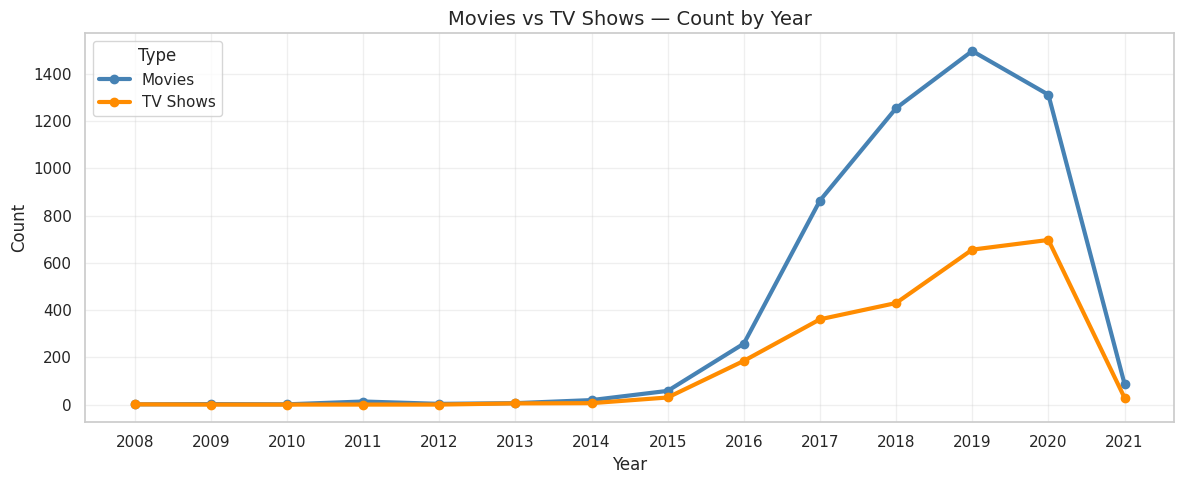

In [19]:
# --- Cleaned & fixed version of "Prepare aggregated table" block ---

# Use the 'category' column which contains 'Movie' and 'TV Show'
category_col = 'category'

# Keep only Movie and TV Show records based on the 'category' column
valid_categories = ['Movie', 'TV Show']
df_filtered = df[df[category_col].isin(valid_categories)].copy()


# Drop rows with NaN values in the year column before grouping
df_filtered.dropna(subset=[year_col], inplace=True)

# Ensure the year column is integer type before grouping
df_filtered[year_col] = df_filtered[year_col].astype(int)

# Prepare aggregated table (Movies vs TV Shows by year)
agg = df_filtered.groupby([year_col, category_col]).size().unstack(fill_value=0)

# Print the aggregated DataFrame for inspection
print("Aggregated DataFrame:")
display(agg)

# Check if the aggregated DataFrame is empty
if agg.empty:
    print("Aggregated DataFrame is empty. No data to plot.")
else:
    # Sort and reindex years
    agg = agg.sort_index()

    # Ensure the index is integer type before creating the range
    agg.index = agg.index.astype(int)

    year_range = range(agg.index.min(), agg.index.max() + 1)
    agg = agg.reindex(year_range, fill_value=0)

    # --- Plot clean 2-line chart ---
    plt.figure(figsize=(12,5))
    plt.plot(agg.index, agg['Movie'], marker='o', linewidth=3, color='steelblue', label='Movies')
    plt.plot(agg.index, agg['TV Show'], marker='o', linewidth=3, color='darkorange', label='TV Shows')

    plt.title('Movies vs TV Shows — Count by Year', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(agg.index[::max(1, len(agg.index)//12)])
    plt.legend(title='Type', frameon=True)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

<Figure size 1200x600 with 0 Axes>

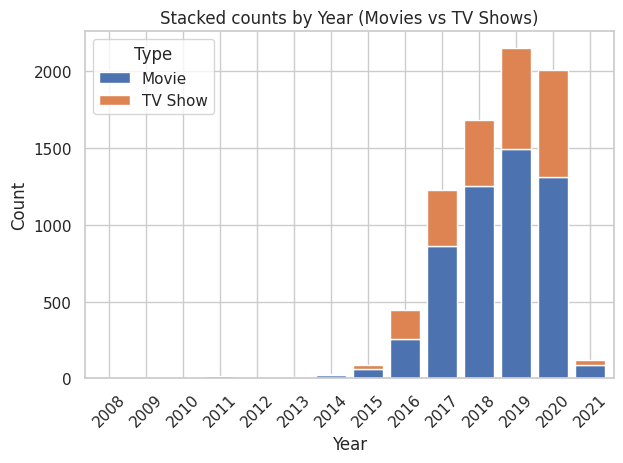

In [20]:
# Part 5C
# Stacked bar
plt.figure(figsize=(12,6))
agg.plot(kind='bar', stacked=True, width=0.8)
plt.title('Stacked counts by Year (Movies vs TV Shows)')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<Figure size 1200x500 with 0 Axes>

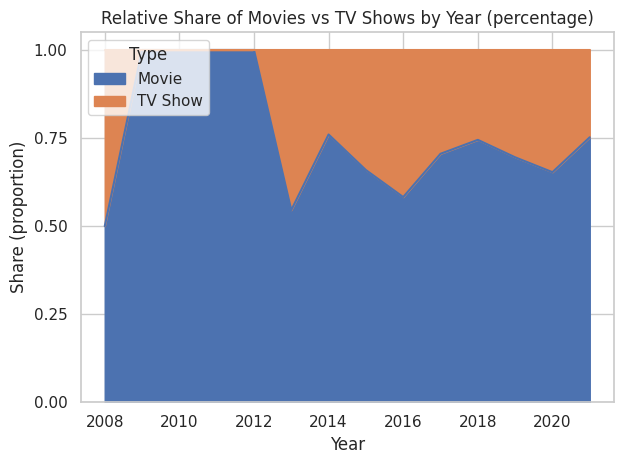

In [21]:
# Part 5D
# Percent composition
agg_pct = agg.div(agg.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)

plt.figure(figsize=(12,5))
agg_pct.plot(kind='area', stacked=True)
plt.title('Relative Share of Movies vs TV Shows by Year (percentage)')
plt.xlabel('Year')
plt.ylabel('Share (proportion)')
plt.yticks([0,0.25,0.5,0.75,1.0])
plt.legend(title='Type', loc='upper left')
plt.tight_layout()
plt.show()


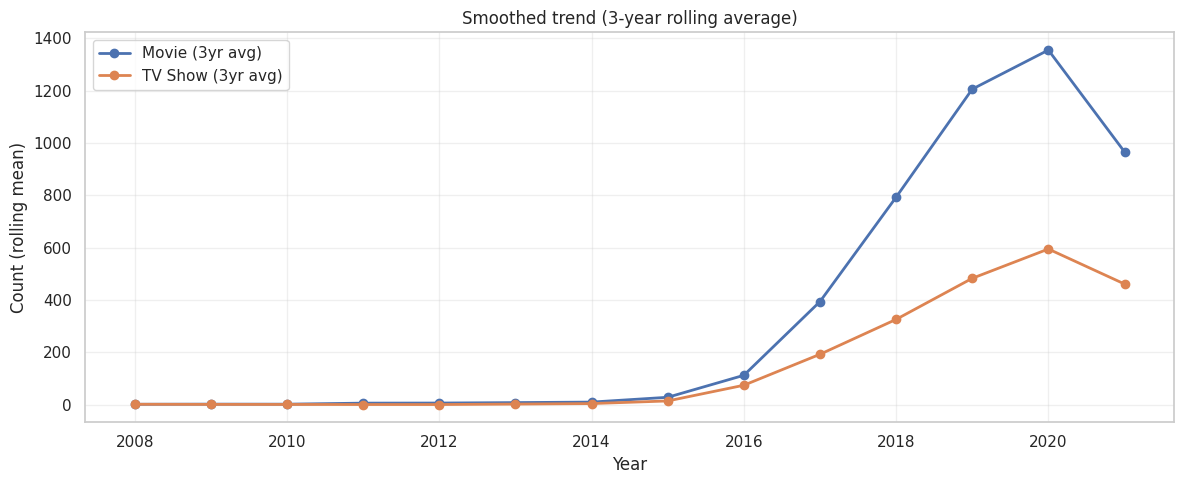

In [22]:
# Part 5E
# 3-year rolling average for smoothing (choose window as needed)
agg_smooth = agg.rolling(window=3, min_periods=1).mean()

plt.figure(figsize=(12,5))
for col in agg_smooth.columns:
    plt.plot(agg_smooth.index, agg_smooth[col], marker='o', linewidth=2, label=f"{col} (3yr avg)")
plt.title('Smoothed trend (3-year rolling average)')
plt.xlabel('Year')
plt.ylabel('Count (rolling mean)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [23]:
# Show unique type values and counts to ensure only two categories remain
print("Final type value counts:")
print(df[type_col].value_counts())

# Show years range and NaNs
print("Year min/max:", agg.index.min(), agg.index.max())
print("Any NaN years in original:", df[year_col].isna().sum())


Final type value counts:
type
Documentaries                                                  334
Stand-Up Comedy                                                321
Dramas, International Movies                                   320
Comedies, Dramas, International Movies                         243
Dramas, Independent Movies, International Movies               215
                                                              ... 
Crime Tv Shows, International Tv Shows, Tv Sci-Fi & Fantasy      1
Docuseries, Science & Nature Tv, Tv Action & Adventure           1
British Tv Shows, Classic & Cult Tv, Kids' Tv                    1
Docuseries, Tv Sci-Fi & Fantasy                                  1
Children & Family Movies, Dramas, Music & Musicals               1
Name: count, Length: 492, dtype: int64
Year min/max: 2008 2021
Any NaN years in original: 10


Top genres overall:


,count
genres_list,
International Movies,2437
Dramas,2106
Comedies,1471
International Tv Shows,1199
Documentaries,786
Action & Adventure,721
Tv Dramas,704
Independent Movies,673
Children & Family Movies,532


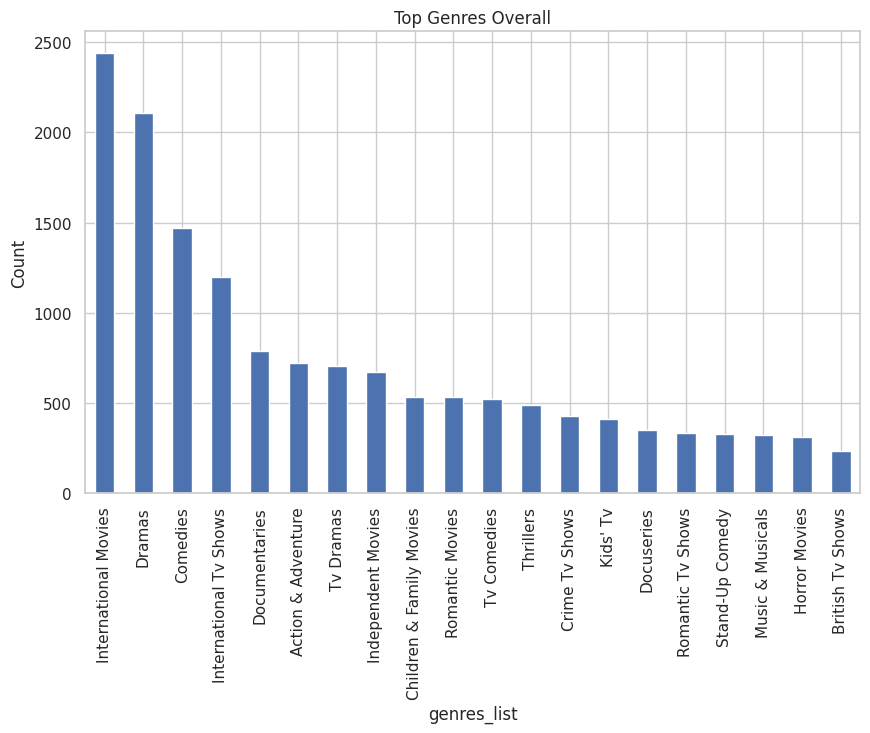

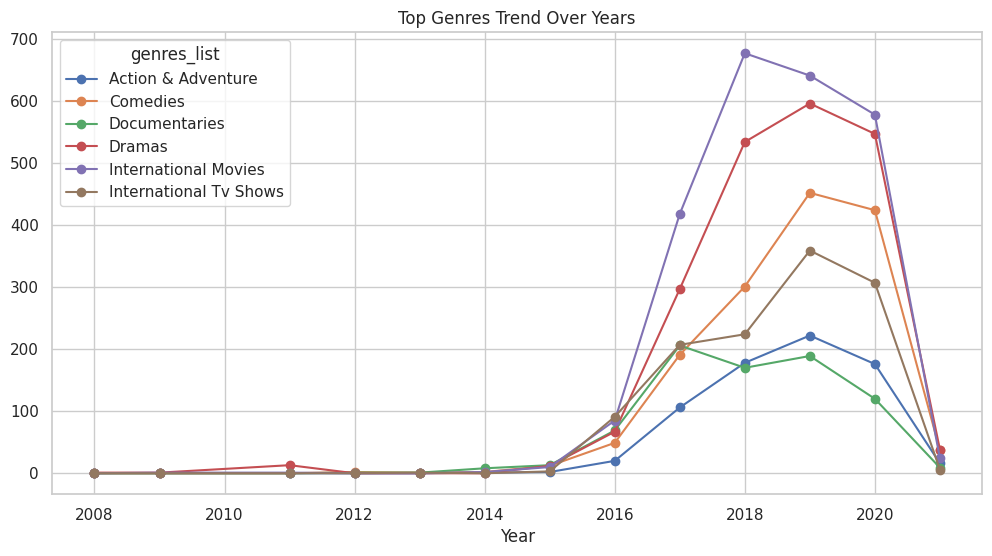

In [24]:
# Part 6: Genre frequency & top genres per year
# explode genres_list
genres_exp = df.explode('genres_list')
genres_exp['genres_list'] = genres_exp['genres_list'].str.title().replace('', np.nan)
top_genres = genres_exp['genres_list'].value_counts().head(20)
print("Top genres overall:")
display(top_genres)

# Plot top genres
plt.figure(figsize=(10,6))
top_genres.plot(kind='bar')
plt.title('Top Genres Overall')
plt.ylabel('Count')
plt.show()

# Genre trend for top 6 genres over years
top6 = top_genres.head(6).index.tolist()
if 'release_year' in df.columns:
    trend = genres_exp[genres_exp['genres_list'].isin(top6)].groupby(['release_year','genres_list']).size().unstack(fill_value=0)
    if trend.shape[0]>0:
        trend.plot(figsize=(12,6), marker='o')
        plt.title('Top Genres Trend Over Years')
        plt.xlabel('Year')
        plt.show()


Top contributing countries:


,count
country,
United States,3297
India,990
United Kingdom,723
Unknown,507
Canada,412
France,349
Japan,287
Spain,215
South Korea,212


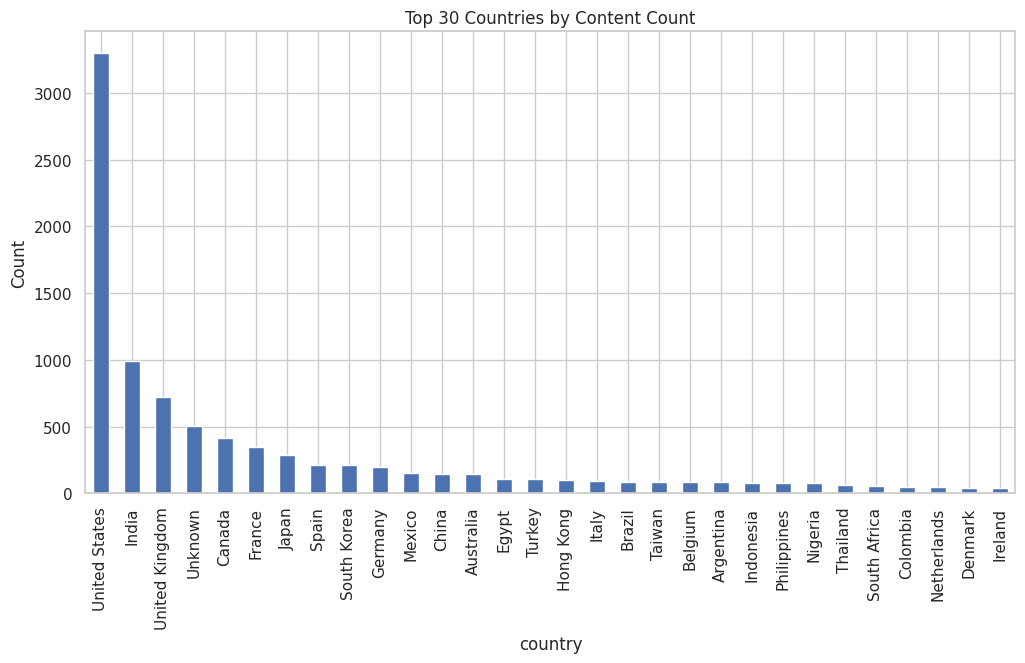

In [25]:
# Part 7: Country analysis
# split country (may be multi-country)
if 'country' in df.columns:
    df['country'] = df['country'].replace('','Unknown')
    df_exp = df.assign(country=df['country'].str.split(',')).explode('country')
    df_exp['country'] = df_exp['country'].str.strip()
    country_counts = df_exp['country'].value_counts().head(30)
    print("Top contributing countries:")
    display(country_counts)

    # Plot top countries
    plt.figure(figsize=(12,6))
    country_counts.plot(kind='bar')
    plt.title('Top 30 Countries by Content Count')
    plt.ylabel('Count')
    plt.show()
else:
    print("No 'country' column in dataset.")


Top Director:


,count
director,
,2388
Jan Suter,21
Raúl Campos,19
Marcus Raboy,16
Jay Karas,15
Cathy Garcia-Molina,13
Youssef Chahine,12
Jay Chapman,12
Martin Scorsese,12


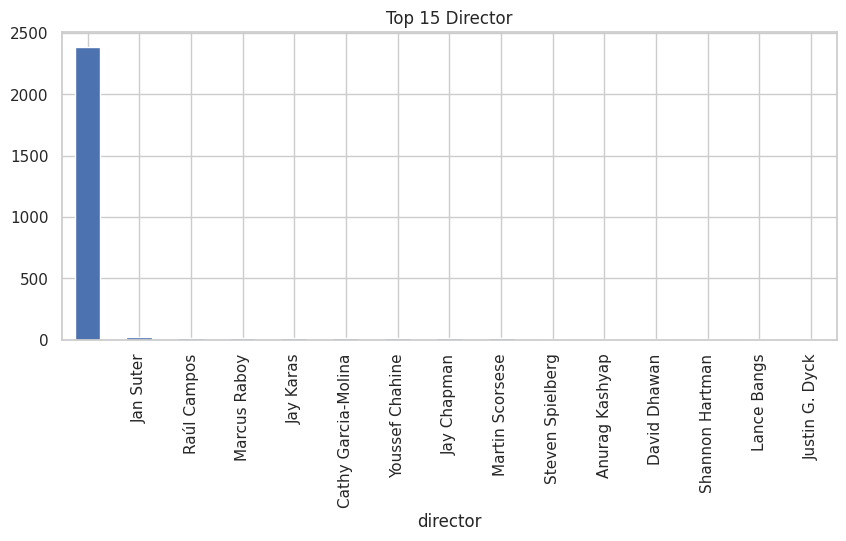

Top Cast:


,count
cast,
,718
Anupam Kher,42
Shah Rukh Khan,35
Naseeruddin Shah,30
Om Puri,30
Akshay Kumar,29
Takahiro Sakurai,29
Paresh Rawal,27
Amitabh Bachchan,27


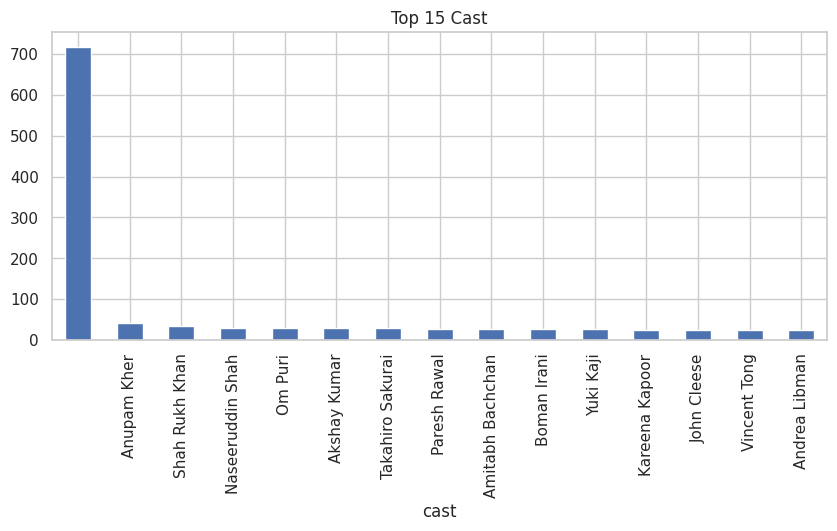

In [26]:
# Part 8: Directors & Cast
for col in ['director','cast']:
    if col in df.columns:
        # explode by comma
        tmp = df.assign(**{col: df[col].str.split(',')}).explode(col)
        tmp[col] = tmp[col].str.strip()
        top = tmp[col].value_counts().head(15)
        print(f"Top {col.title()}:")
        display(top)
        plt.figure(figsize=(10,4))
        top.plot(kind='bar')
        plt.title(f'Top 15 {col.title()}')
        plt.show()


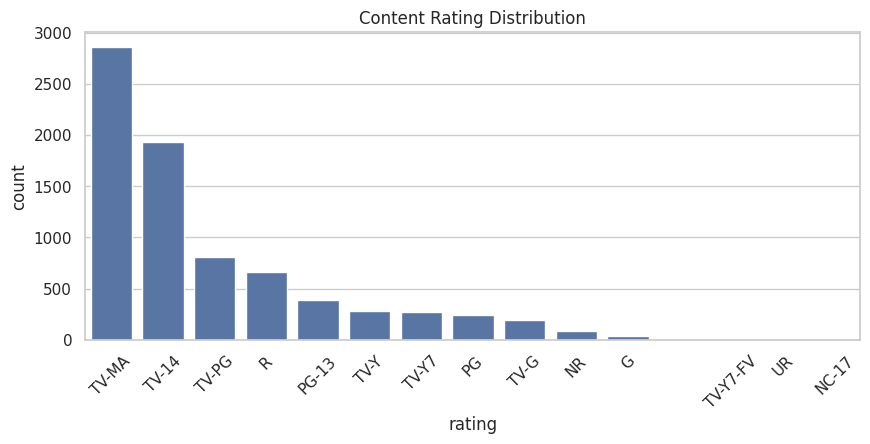

,,count,mean,std,min,25%,50%,75%,max
type,duration_unit,,,,,,,,
Action & Adventure,minutes,99.0,105.121212,17.750121,77.0,92.5,102.0,114.50,191.0
"Action & Adventure, Anime Features, Children & Family Movies",minutes,3.0,102.666667,4.509250,98.0,100.5,103.0,105.00,107.0
"Action & Adventure, Anime Features, Classic Movies",minutes,1.0,100.000000,NaN,100.0,100.0,100.0,100.00,100.0
"Action & Adventure, Anime Features, Horror Movies",minutes,1.0,96.000000,NaN,96.0,96.0,96.0,96.00,96.0
"Action & Adventure, Anime Features, International Movies",minutes,28.0,85.964286,22.361478,5.0,76.5,92.5,99.25,121.0
...,...,...,...,...,...,...,...,...,...
"Tv Horror, Tv Mysteries, Teen Tv Shows",seasons,1.0,1.000000,NaN,1.0,1.0,1.0,1.00,1.0
"Tv Horror, Tv Mysteries, Tv Sci-Fi & Fantasy",seasons,4.0,2.250000,1.500000,1.0,1.0,2.0,3.25,4.0
"Tv Horror, Tv Mysteries, Tv Thrillers",seasons,4.0,4.500000,3.000000,3.0,3.0,3.0,4.50,9.0


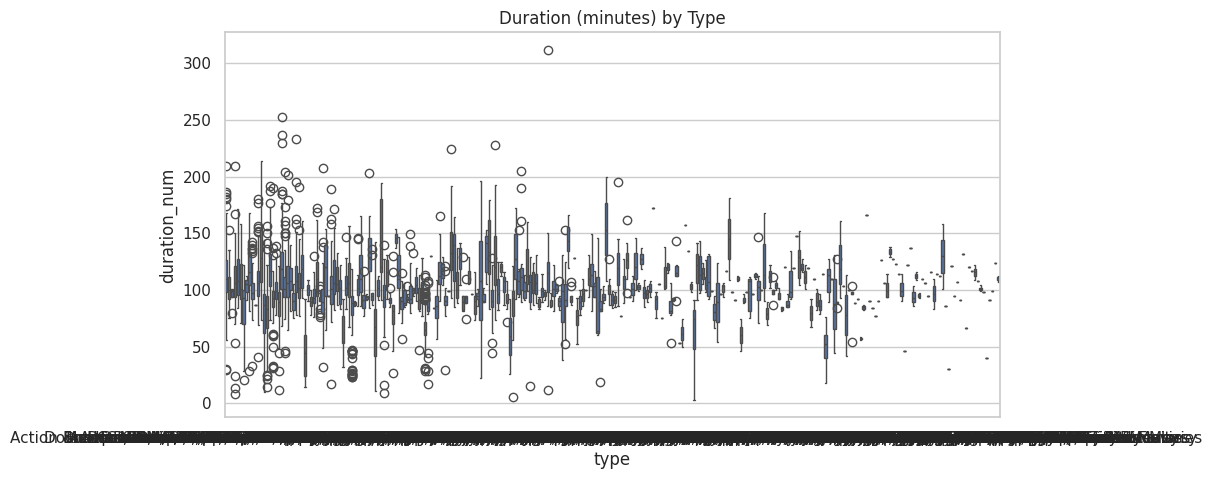

In [27]:
# Part 9: Ratings & Duration
if 'rating' in df.columns:
    plt.figure(figsize=(10,4))
    sns.countplot(data=df, x='rating', order=df['rating'].value_counts().index)
    plt.title('Content Rating Distribution')
    plt.xticks(rotation=45)
    plt.show()

# duration vs type
if 'duration_num' in df.columns and 'duration_unit' in df.columns:
    display(df.groupby(['type','duration_unit'])['duration_num'].describe())
    plt.figure(figsize=(10,5))
    sns.boxplot(data=df[df['duration_unit']=='minutes'], x='type', y='duration_num')
    plt.title('Duration (minutes) by Type')
    plt.show()


In [28]:
# Part 10: Combine attributes for insights
# Example: Most common genre per country (top 10 countries)
if 'country' in df.columns:
    top_countries = df_exp['country'].value_counts().head(10).index.tolist()
    rows = []
    for c in top_countries:
        sub = genres_exp[genres_exp['country'].str.strip()==c]
        if sub.empty:
            # join country - you may need to ensure genres_exp has country info, else join original df
            sub = df[df['country'].str.contains(c, na=False)].explode('genres_list')
        top_gen = sub['genres_list'].value_counts().head(3).index.tolist()
        rows.append({'country':c,'top_genres':top_gen})
    import pandas as pd
    display(pd.DataFrame(rows))


,country,top_genres
0,United States,"[Dramas, Comedies, Documentaries]"
1,India,"[International Movies, Dramas, Comedies]"
2,United Kingdom,"[British Tv Shows, International Tv Shows, Doc..."
3,Unknown,"[International TV Shows, International Movies,..."
4,Canada,"[Comedies, Children & Family Movies, Internati..."
5,France,"[International Movies, International Tv Shows,..."
6,Japan,"[International Tv Shows, Anime Series, Anime F..."
7,Spain,"[International Movies, International Tv Shows,..."
8,South Korea,"[International Tv Shows, Korean Tv Shows, Roma..."
9,Germany,"[International Movies, International Tv Shows,..."


In [29]:
# Part 11: Auto-generate summary points (basic)
summary = []

# 1) Movies vs TVShows counts
if 'type' in df.columns:
    type_counts = df['type'].value_counts()
    summary.append(f"Movies vs TV Shows counts: {type_counts.to_dict()}")

# 2) Top genres
summary.append("Top genres overall: " + ", ".join(top_genres.head(6).index.tolist()))

# 3) Top countries
if 'country' in df.columns:
    summary.append("Top contributing countries: " + ", ".join(country_counts.head(6).index.tolist()))

# Print summary
for i,s in enumerate(summary,1):
    print(f"{i}. {s}")


1. Movies vs TV Shows counts: {'Documentaries': 334, 'Stand-Up Comedy': 321, 'Dramas, International Movies': 320, 'Comedies, Dramas, International Movies': 243, 'Dramas, Independent Movies, International Movies': 215, "Kids' Tv": 205, 'Children & Family Movies': 177, 'Documentaries, International Movies': 172, 'Children & Family Movies, Comedies': 169, 'Comedies, International Movies': 161, 'Dramas, International Movies, Romantic Movies': 153, 'Comedies, International Movies, Romantic Movies': 139, 'Action & Adventure, Dramas, International Movies': 117, 'Dramas': 117, 'International Tv Shows, Tv Dramas': 111, 'Dramas, International Movies, Thrillers': 109, 'Crime Tv Shows, International Tv Shows, Tv Dramas': 106, 'Comedies, Dramas, Independent Movies': 101, 'Action & Adventure': 99, 'Comedies': 97, 'Dramas, Independent Movies': 94, "Kids' Tv, Tv Comedies": 90, 'Action & Adventure, International Movies': 88, 'International Tv Shows, Romantic Tv Shows, Tv Dramas': 86, 'Reality Tv': 83, 

In [30]:
# Part 12: Generate recommendation template (editable)
recommendations = [
    "Increase investment in top-performing genres identified (see Top Genres).",
    "If certain countries are underrepresented, consider content acquisition/production targeting those markets.",
    "Balance between Movies and TV Shows: if TV Shows growth is strong in recent years, invest in series development.",
    "Leverage top directors/actors for regional originals to boost engagement in key markets.",
    "Use rating and duration patterns to plan release strategies (e.g., longer formats for binge-prone audiences)."
]

for r in recommendations:
    print("-", r)


- Increase investment in top-performing genres identified (see Top Genres).
- If certain countries are underrepresented, consider content acquisition/production targeting those markets.
- Balance between Movies and TV Shows: if TV Shows growth is strong in recent years, invest in series development.
- Leverage top directors/actors for regional originals to boost engagement in key markets.
- Use rating and duration patterns to plan release strategies (e.g., longer formats for binge-prone audiences).


In [31]:
# Part 13: Save cleaned dataset and key outputs
os.makedirs('/mnt/data/output', exist_ok=True)
df.to_csv('/mnt/data/output/netflix_cleaned.csv', index=False)
print("Saved cleaned dataset to /mnt/data/output/netflix_cleaned.csv")

# Example: save top genres csv
top_genres.to_csv('/mnt/data/output/top_genres.csv', header=['count'])
print("Saved top_genres.csv")


Saved cleaned dataset to /mnt/data/output/netflix_cleaned.csv
Saved top_genres.csv
